In [18]:
import __init__
import numpy as np
import os
import pandas as pd
from datapath_manager import ITWDataPathManager, DataPathManager
from date_time_utils import get_date_time_from_float, convert_utc_to_local_time
from trainers import MachineLearningModelTrainer, BranchNeuralNetworkTrainer
import matplotlib.pyplot as plt
from dataloader import EmbeddingDataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, roc_auc_score, roc_curve
import yaml, torch
from collections import Counter
from combine_features_itw import ITWFeatureCombiner
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from evaluators import Evaluator
import shap
import lightgbm as lgb
import scikitplot as skplt
import matplotlib.pyplot as plt

/home/nmduy/anaconda3/envs/stress/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
dataset_name = 'DCU_EXP2_ITW'
# user_id = 'lzhou'
# dates = ['2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16']
# user_id = 'tlduyen'
# dates = ['2022-09-27', '2022-09-28', '2022-09-30', '2022-10-01', '2022-10-02', '2022-10-03']
user_id = 'ltkhiem'
dates = ['2022-10-16', '2022-10-17', '2022-10-18', '2022-10-20', '2022-10-21', '2022-10-22']

trained_dataset_name = 'DCU_NVT_EXP2'
dl_model_name = 'branch_neural_network'
ml_model_name = 'extra_trees'
model_type = 'dependent'
signal_type = 'bvp_eda_temp'
window_size = 60
window_shift = 0.25
feature_names = [line.strip() for line in open('feature_names.txt', 'r').readlines()]

In [20]:
def get_pretrained_model(model_name):
    ds_path_manager = DataPathManager(trained_dataset_name)
    user_model_saved_path = ds_path_manager.get_saved_model_path(user_id, model_name, model_type, window_size, window_shift)
    if model_name == 'branch_neural_network':
        config_path = os.path.join(os.path.dirname(os.getcwd()), 'models', 'model_config', 'branchnn_sensor_combination.yaml')
        config_dict = yaml.safe_load(open(config_path, 'r'))
        model = BranchNeuralNetworkTrainer('.', user_model_saved_path, config_dict, target_metrics=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    else:
        model = MachineLearningModelTrainer(user_model_saved_path, model_name, eval_mode = True, target_metrics = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'])
    return model

In [21]:
def boxplot_by_features(X, Y, Z = None, T = None, labels = ['Stress', 'Relax']):
    """
    X: feature matrix
    Y: feature matrix
    X and Y should have the same number of rows
    """
    nrows, ncols = 12, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 50))

    num_features = X.shape[1]
    for i in range(num_features):
        data = [X[:, i], Y[:, i]]
        if Z is not None:
            if Z.shape[0] == 0:
                data.append([])
            else:
                data.append(Z[:, i])
        if T is not None:
            data.append(T[:, i])
        x, y = i // ncols, i % ncols
        ax[x, y].boxplot(data, labels=labels)
        ax[x, y].set_title(feature_names[i])

In [22]:
def get_features_and_labels(user_id: str, date: str,):
    dataset_path = ITWDataPathManager(dataset_name).get_dataset_path()
    user_date_path = os.path.join(dataset_path, 'data', user_id, date, 'Lifelog')

    user_date_feature_path = os.path.join(dataset_path, 'features', user_id, date)
    feature_path = os.path.join(user_date_feature_path, 'X.npy')
    gt_path = os.path.join(user_date_feature_path, 'y.npy')

    feat = np.nan_to_num(np.load(feature_path))[:, :72]
    gt = np.load(gt_path)
    return feat, gt

In [23]:
feat_dates = [get_features_and_labels(user_id, date) for date in dates]
for x in feat_dates:
    print(Counter(x[1]))

Counter({0.0: 16619, 1.0: 1242})
Counter({0.0: 30000, 1.0: 7224})
Counter({0.0: 39579, 1.0: 6050})
Counter({0.0: 48606})
Counter({0.0: 23292, 1.0: 5447})
Counter({0.0: 7408, 1.0: 2120})


In [24]:
# Use the first 3 days for training
X_train = np.concatenate([x[0] for x in feat_dates[:3]])
y_train = np.concatenate([x[1] for x in feat_dates[:3]]).astype(int)
# Use the last 3 days for testing
X_test = np.concatenate([x[0] for x in feat_dates[3:]])
y_test = np.concatenate([x[1] for x in feat_dates[3:]]).astype(int)
# X_train = feat_dates[0][0]
# y_train = feat_dates[0][1].astype(int)
# X_test = np.concatenate([x[0] for x in feat_dates[1:]])
# y_test = np.concatenate([x[1] for x in feat_dates[1:]]).astype(int)

In [25]:
X_train_stress = X_train[y_train == 1]
X_train_relax = X_train[y_train == 0]
X_test_stress = X_test[y_test == 1]
X_test_relax = X_test[y_test == 0]

In [26]:
# boxplot_by_features(X_train_stress, X_train_relax, X_test_stress, X_test_relax, labels = ['TrainS', 'TrainR', 'TestS', 'TestR'])

In [27]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
Counter(y_train), Counter(y_test)

(Counter({0: 86198, 1: 14516}), Counter({0: 79306, 1: 7567}))

In [29]:
train_dataloader = EmbeddingDataLoader(X_train, y_train)
validate_dataloader = EmbeddingDataLoader(X_test, y_test)

In [30]:
user_model_saved_path = f'{user_id}_{signal_type}.pth'
config_path = os.path.join(os.path.dirname(os.getcwd()), 'models', 'model_config', f'branchnn_sensor_combination_{signal_type}.yaml')
config_dict = yaml.safe_load(open(config_path, 'r'))
clf = BranchNeuralNetworkTrainer('./logs.txt', 
    user_model_saved_path, config_dict, 
    # target_metrics=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'],
    target_metrics=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1'],
)
# clf.train(train_dataloader, validate_dataloader, num_epochs=1000)

In [14]:
y_pred = clf.predict(validate_dataloader)
print(Evaluator().evaluate(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Relaxed', 'Stress'])

AttributeError: 'StandardScaler' object has no attribute 'mean_'

{'accuracy': 0.6149095458426832, 'balanced_accuracy': 0.6451569978930065, 'precision': 0.2256737203834328, 'recall': 0.68765500137779, 'f1': 0.3398243344454279}


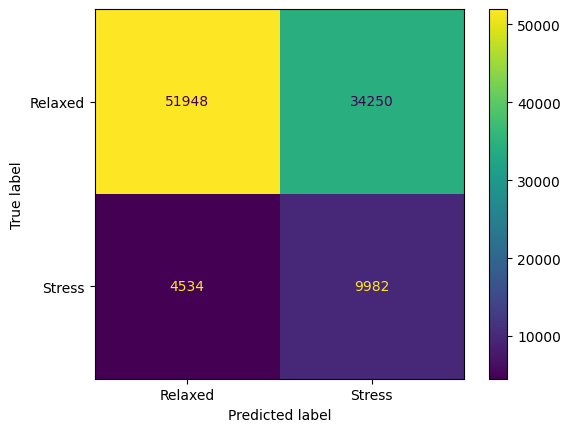

In [ ]:
y_pred_train = clf.predict(train_dataloader)
print(Evaluator().evaluate(y_train, y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=['Relaxed', 'Stress'])

In [15]:
clf = ExtraTreesClassifier(
    n_estimators = 500,
    random_state = 0, 
    n_jobs = -1, 
    max_features = 'sqrt', 
    max_depth = 8, 
    min_samples_split = 2, 
    min_samples_leaf = 8,
    oob_score = True, 
    bootstrap = True, 
    class_weight = 'balanced'
)
# clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1, weights='distance')
# clf = LogisticRegression(
#     random_state=0, 
#     max_iter=10000, 
#     n_jobs=-1, 
#     class_weight='balanced'
# )
# clf = make_pipeline(
#     RandomUnderSampler(random_state=0),
#     ExtraTreesClassifier(
#         n_estimators = 500,
#         random_state = 0,
#         n_jobs = -1,
#         max_features = 'sqrt',
#         max_depth = 8,
#         min_samples_split = 2,
#         min_samples_leaf = 8,
#         oob_score = True,
#         bootstrap = True,
#     )
# )
clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, class_weight='balanced', max_depth=8,
                     min_samples_leaf=8, n_estimators=500, n_jobs=-1,
                     oob_score=True, random_state=0)

In [ ]:
pred = clf.predict_proba(X_test)[:, 1]

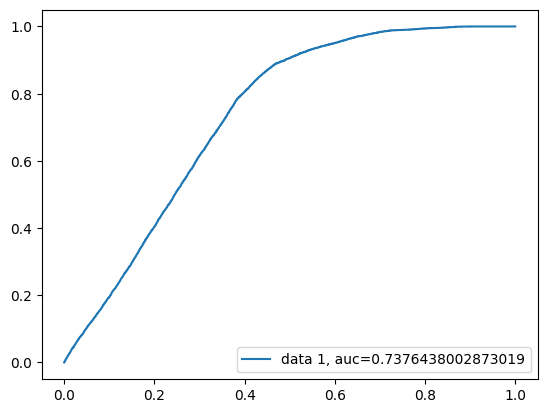

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
youdenJ = tpr - fpr
index = np.argmax(youdenJ)
thresholdOpt = round(thresholds[index], ndigits = 4)
thresholdOpt

0.4474

In [ ]:
thresholds

array([1.66119533, 0.66119533, 0.65179871, ..., 0.17472898, 0.17471788,
       0.0188271 ])

In [ ]:
preds = np.where(pred > 0.5, 1, 0)

{'accuracy': 0.6798314781347484, 'balanced_accuracy': 0.6658876514300742, 'precision': 0.1633243539858326, 'recall': 0.6490022465970662, 'f1': 0.260973535976193}


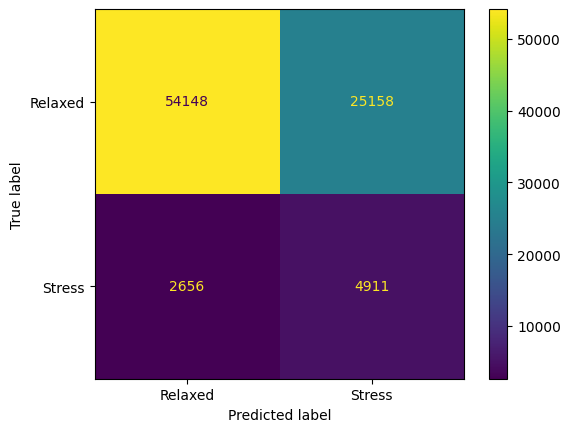

In [ ]:
y_pred = clf.predict(X_test)
y_pred = preds
print(Evaluator().evaluate(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Relaxed', 'Stress'])

{'accuracy': 0.6262982306332784, 'balanced_accuracy': 0.7414664802666384, 'precision': 0.26572094437126353, 'recall': 0.9032791402590246, 'f1': 0.4106418627957595}


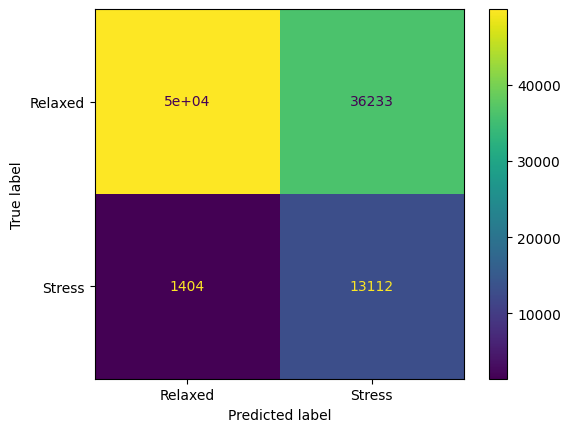

In [ ]:
lrrlasdsadasdkl;jklasklaaaaaaaaaggggaaaqweqwe112213aaaaaaaaaaaaaaasqweqey_train_pred = clf.predict(X_train)
print(Evaluator().evaluate(y_train, y_train_pred))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Relaxed', 'Stress'])

In [31]:
lr_classifier = LogisticRegression(
    random_state = 0,
    class_weight = 'balanced',
    n_jobs = -1,
    solver = 'saga',
    max_iter = 5000,
)

In [32]:
lr_classifier.fit(X_train, y_train)

The max_iter was reached which means the coef_ did not converge


LogisticRegression(class_weight='balanced', max_iter=5000, n_jobs=-1,
                   random_state=0, solver='saga')

{'accuracy': 0.7402184798498959, 'balanced_accuracy': 0.6251440335367886, 'precision': 0.16445219881000314, 'recall': 0.48579357737544604, 'f1': 0.24572192513368984}


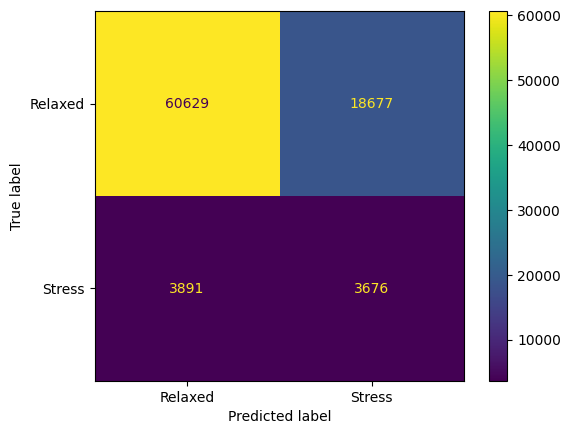

In [33]:
y_pred = lr_classifier.predict(X_test)
print(Evaluator().evaluate(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Relaxed', 'Stress'])

{'accuracy': 0.6170443036717834, 'balanced_accuracy': 0.6520183803883413, 'precision': 0.22918777725235875, 'recall': 0.7011573436208322, 'f1': 0.34545608824777263}


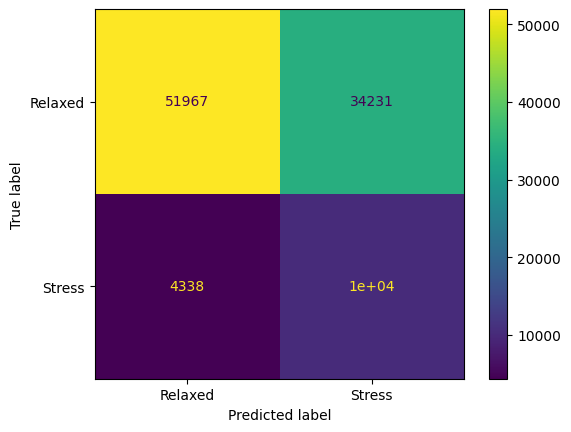

In [34]:
y_pred_train = lr_classifier.predict(X_train)
print(Evaluator().evaluate(y_train, y_pred_train))
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, display_labels=['Relaxed', 'Stress'])

In [35]:
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(X_test[:1000])
explainer = shap.explainers.Linear(lr_classifier, X_train, feature_names = feature_names[:72])
shap_values = explainer(X_test)

In [49]:
exp = shap.Explainer(lr_classifier, X_train, feature_names = feature_names[:72])
sv = exp(X_test)

In [62]:
shap.plots.summary(shap_values, max_display=10)

AttributeError: module 'shap.plots' has no attribute 'summary'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

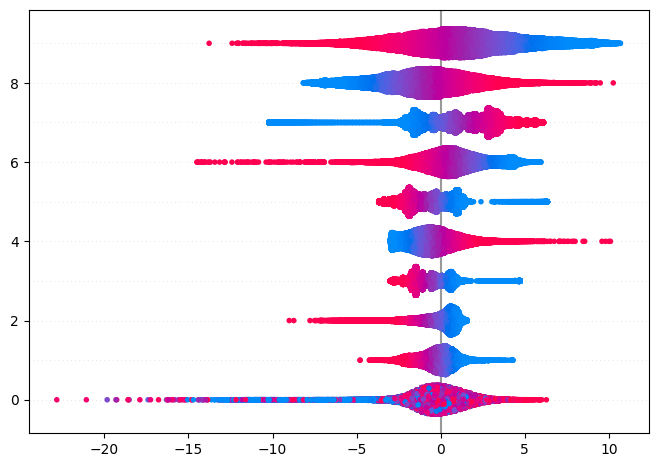

In [65]:
shap.plots.beeswarm(shap_values, max_display=10)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

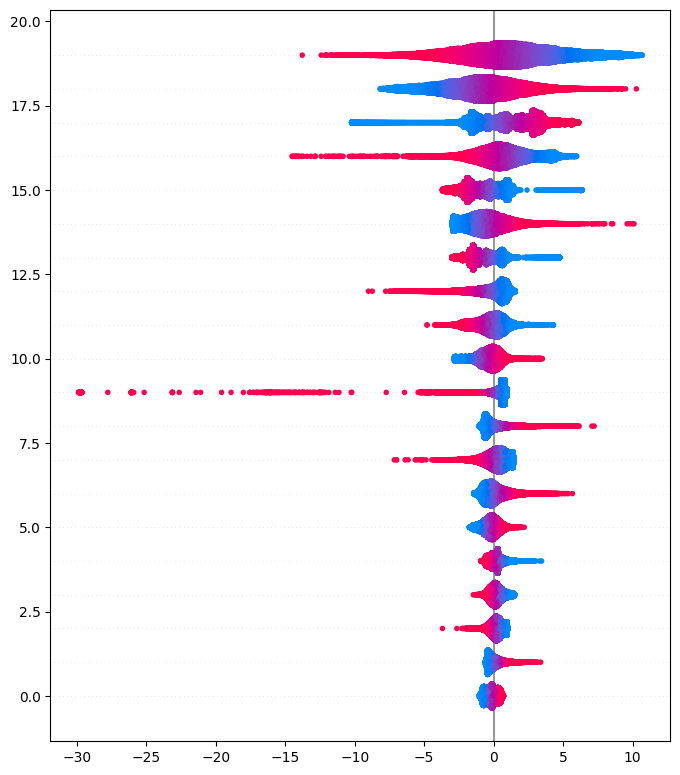

In [64]:
shap.summary_plot(sv, X_test, feature_names = feature_names[:72])

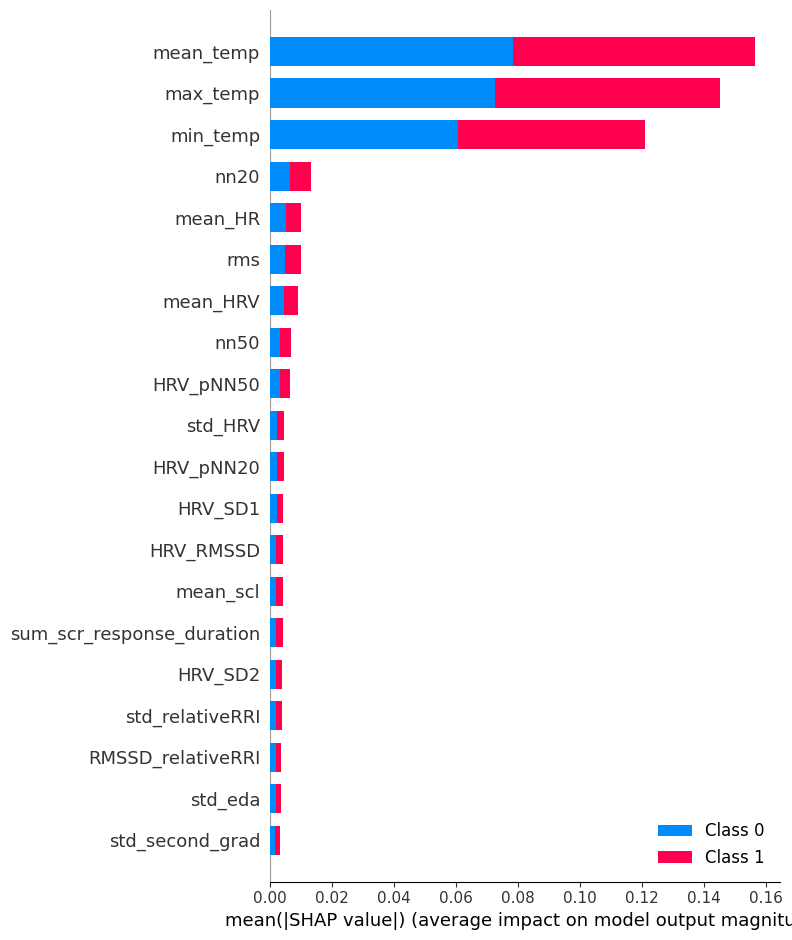

In [ ]:
shap.summary_plot(shap_values, X_test, feature_names=feature_names[:72], plot_type='bar')